# 15.066 Summer 2025
## System Optimization and Analysis for Operations
### final Project - Group 5A
---
Grayson Adams, Shane Pornprinya, Becca Sholler

---

## Load Packages

In [1]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from project_data import *
%whos

Variable       Type       Data/Info
-----------------------------------
CE             ndarray    7: 7 elems, type `float64`, 56 bytes
CEU            ndarray    9x7: 63 elems, type `float64`, 504 bytes
GRB            type       <class 'gurobipy._grb.GRB'>
MaxProd        float      600000.0
MinAir32       float      53000.0
MinAir42       float      46000.0
MinProd        float      200000.0
MinRail32      float      79500.0
MinRail42      float      138000.0
MinRoad32      float      79500.0
MinRoad42      float      92000.0
NumODM         int        9
NumTran        int        7
OEMD           ndarray    9x7: 63 elems, type `int64`, 504 bytes
PSCU           ndarray    9x7: 63 elems, type `float64`, 504 bytes
SCMT           ndarray    9x7: 63 elems, type `float64`, 504 bytes
TotalBudget    float      3000000000.0
TotalUnits32   float      530000.0
TotalUnits42   float      920000.0
UPC            ndarray    9: 9 elems, type `float64`, 72 bytes
gp             module     <module 'gurobip

In [2]:
# Set up Gurobi environment
env = gp.Env(empty=True)
env.setParam('OutputFlag', 0)
env.start()

# Initialize the model
m = gp.Model(env=env)

---
## Optimization Case Details

In [ ]:
state = 'WA'
TotalDemand = STATES[state]['Demand']

---
## Decision Variables

In [ ]:
### Decision Variables ###

## Continuous
# A vector of qty of each fuel type
F = m.addMVar(NUMFT, vtype=GRB.CONTINUOUS, name='Fuel') # For single day
# F = m.addMVar((NUMFT,24), vtype=GRB.CONTINUOUS, name='Fuel') # Split into hours

## Binary
# Whether or not to use nuclear (given minimum constraint)
XNuclear = m.addVar(vtype=GRB.BINARY, lb=0, name='FNuclear') 

---
## Objective Function

In [ ]:
# Objective function: minimize cost
m.setObjective(gp.quicksum(F[i]*C[i] for i in range(NUMFT)),GRB.MINIMIZE)

---
## Constraints

In [ ]:
### Constraints ###
# Total production must meet demand
Const1 = m.addConstrs(gp.quicksum(F[i] for i in range(NUMFT))>=TotalDemand)

# Total CO2 emissions must be less than limit
Const2 = m.addConstrs(gp.quicksum(F[i]*E[i] for i in range(NUMFT))<=MAXCO2)

# Total number of TVs for each shipping mode must be greater than the Minimum Shipping Requirement
Const3 = m.addConstr(gp.quicksum(SCM[i,j] for i in range(0,7) for j in range(0,2))>=MinAir42, name='Const2a1') # 42" Regular Air or Air Express
Const2b1 = m.addConstr(gp.quicksum(SCM[i,j] for i in range(0,7) for j in range(2,5))>=MinRoad42, name='Const2b1')  # 42" Road, Road LTL, or Road Network
Const2c1 = m.addConstr(gp.quicksum(SCM[i,5] for i in range(0,7))>=MinRail42, name='Const2c1')  # 42" Rail
Const2a2 = m.addConstr(gp.quicksum(SCM[i,j] for i in range(7,9) for j in range(0,2))>=MinAir32, name='Const2a2')  # 32" Regular Air or Air Express
Const2b2 = m.addConstr(gp.quicksum(SCM[i,j] for i in range(7,9) for j in range(2,5))>=MinRoad32, name='Const2b2')  # 32" Road, Road LTL, or Road Network
Const2c2 = m.addConstr(gp.quicksum(SCM[i,5] for i in range(7,9))>=MinRail32, name='Const2c2')  # 32" Rail


---
## Solve

In [6]:
# Update and write the model
m.update() # Update model parameters
m.write("15066_final_project_5A.lp") # Write model to file
m.optimize() # Solve

In [7]:
# Print optimal objective function value
initObjVal = m.getAttr("ObjVal")
print("\nObjective value: ", "%.2f" % initObjVal)


Objective value:  7401309.89


In [8]:
# Print the optimal decsion variable solutions
transport_names = ['Air', 'Express', 'Road', 'Road LTL', 'Road-Network', 'Rail', 'Water']
ODM_names = ['LCD 42" ODM1', 'LCD 42" ODM2', 'LCD 42" ODM3', 'LCD 42" ODM4', 'LCD 42" ODM5', 
             'LCD 42" ODM6', 'LCD 42" ODM7', 'LCD 32" ODM1', 'LCD 32" ODM2']

initSoln = pd.DataFrame(SCM.getAttr('x'), index=ODM_names, columns=transport_names)
display(initSoln)

,Air,Express,Road,Road LTL,Road-Network,Rail,Water
"LCD 42"" ODM1",0.0,0.0,0.0,0.0,90450.0,0.0,229550.0
"LCD 42"" ODM2",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"LCD 42"" ODM3",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"LCD 42"" ODM4",46000.0,0.0,0.0,0.0,1550.0,138000.0,414450.0
"LCD 42"" ODM5",-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0
"LCD 42"" ODM6",0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0
"LCD 42"" ODM7",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"LCD 32"" ODM1",53000.0,0.0,0.0,0.0,79500.0,79500.0,318000.0
"LCD 32"" ODM2",0.0,0.0,0.0,0.0,0.0,0.0,0.0


---
## Review Constraints

In [9]:
# Calculate used budget
leftoverBudget = m.getConstrByName('Const5').Slack
print(f'Leftover Budget: $',(leftoverBudget))
print(f'Budget % Used: ',((TotalBudget-leftoverBudget)/TotalBudget)*100,'%')

Leftover Budget: $ 0.0
Budget % Used:  100.0 %


---
## Senstivity Analysis

In [10]:
newTotalBudget = TotalBudget*1.1
# Hint: You can change the value of the total budget with this command, by changing the right
# hand side of Constraint 5, be sure constraint 5 is named 'Const5'
m.getConstrByName('Const5').setAttr('RHS', newTotalBudget)

# Re-solve
m.update()
m.optimize()

# Print optimal objective function value
newObjVal = m.getAttr("ObjVal")
print(f"New Co2 Emissions Objective value: ","%.0f" %  newObjVal)
print(f"Pct Change in Objective value: ","%.1f" % ((newObjVal-initObjVal)/initObjVal*100))

newSoln = pd.DataFrame(SCM.getAttr('x'), index=ODM_names, columns=transport_names)
print("Change from Initial Solution")
display(newSoln-initSoln)

# sensitivity table
budget_sensitivity = [1.0, 1.02, 1.04, 1.06, 1.1, 1.12, 1.14,] # FILL-IN

# We will create a vector of emissions by looping through budget_sensitivity
emissions = []
for sensitivity in budget_sensitivity:
    newTotalBudget = TotalBudget*sensitivity
    m.getConstrByName('Const5').setAttr('RHS', newTotalBudget)

    # Re-solve
    m.update()
    m.optimize()

    # Print optimal objective function value
    emissions.append(m.getAttr("ObjVal"))
    
print(emissions)

New Co2 Emissions Objective value:  3479982
Pct Change in Objective value:  -53.0
Change from Initial Solution


,Air,Express,Road,Road LTL,Road-Network,Rail,Water
"LCD 42"" ODM1",0.0,0.0,0.0,0.0,-90450.0,0.0,-229550.0
"LCD 42"" ODM2",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"LCD 42"" ODM3",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"LCD 42"" ODM4",-46000.0,0.0,0.0,0.0,-1550.0,-138000.0,-94450.0
"LCD 42"" ODM5",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"LCD 42"" ODM6",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"LCD 42"" ODM7",46000.0,0.0,0.0,0.0,92000.0,138000.0,324000.0
"LCD 32"" ODM1",-53000.0,0.0,0.0,0.0,-79500.0,-79500.0,-318000.0
"LCD 32"" ODM2",53000.0,0.0,0.0,0.0,79500.0,79500.0,318000.0


[7401309.890260001, 5513060.483081696, 4542391.076797709, 3572591.4892011224, 3479982.2601499995, 3416981.6962133604, 3373499.982068513]


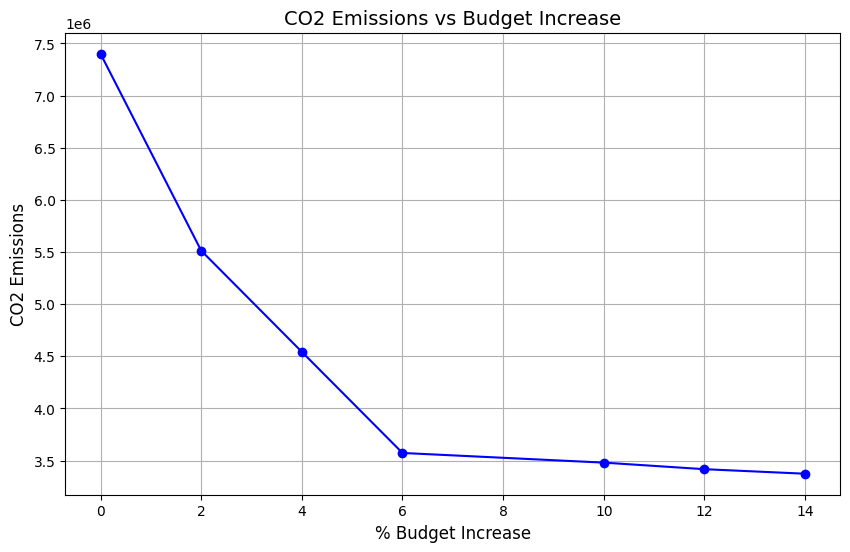

In [11]:
# Graph results
plt.figure(figsize=(10, 6))
plt.plot([((x - 1) * 100) for x in budget_sensitivity], emissions, marker='o', linestyle='-', color='b')
plt.title('CO2 Emissions vs Budget Increase', fontsize=14)
plt.xlabel('% Budget Increase', fontsize=12)
plt.ylabel('CO2 Emissions', fontsize=12)
plt.grid(True)
plt.show()